In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
plt.ion()   # interactive mode

In [2]:
def train(model, device, train_loader, optimizer, criterion, scheduler):    
    EPOCHS = 50
    for epoch in range(EPOCHS):
        losses = []
        running_loss = 0
        for i, inp in enumerate(train_loader):
            inputs, labels = inp
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i%100 == 0 and i > 0:
                print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
                running_loss = 0.0

        avg_loss = sum(losses)/len(losses)
        scheduler.step(avg_loss)

    print('Training Done')

In [3]:
def test(model, device, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=64, num_workers=4, pin_memory=True)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Files already downloaded and verified
Files already downloaded and verified
Tesla V100-PCIE-32GB


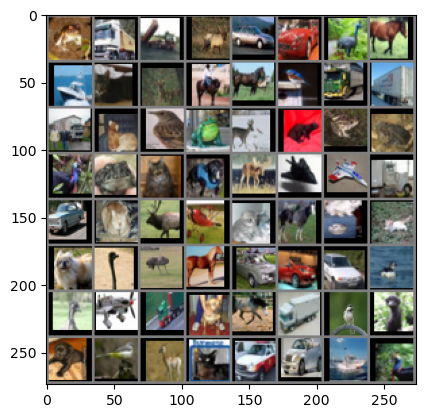

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = dataset_train.classes
imshow(out)

Fine-tuning 

In [6]:
model= models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [8]:
start_time = timeit.default_timer()
train(model, device, train_loader, optimizer, criterion, scheduler)
print(timeit.default_timer() - start_time)
test(model, device, test_loader)

Loss [1, 100](epoch, minibatch):  7.0830815267562866
Loss [1, 200](epoch, minibatch):  2.521433072090149
Loss [1, 300](epoch, minibatch):  2.2284220170974733
Loss [1, 400](epoch, minibatch):  2.1180155229568483
Loss [1, 500](epoch, minibatch):  2.0273668718338014
Loss [1, 600](epoch, minibatch):  2.006274725198746
Loss [1, 700](epoch, minibatch):  1.9652658772468568
Loss [2, 100](epoch, minibatch):  1.9506026458740235
Loss [2, 200](epoch, minibatch):  1.9109705448150636
Loss [2, 300](epoch, minibatch):  1.881249680519104
Loss [2, 400](epoch, minibatch):  1.8470779955387115
Loss [2, 500](epoch, minibatch):  1.8116790008544923
Loss [2, 600](epoch, minibatch):  1.817719224691391
Loss [2, 700](epoch, minibatch):  1.763253753185272
Loss [3, 100](epoch, minibatch):  1.7125829255580902
Loss [3, 200](epoch, minibatch):  1.6771868097782134
Loss [3, 300](epoch, minibatch):  1.6785345482826233
Loss [3, 400](epoch, minibatch):  1.6371944165229797
Loss [3, 500](epoch, minibatch):  1.610589027404785